# Use pre-trained VGG16 model

[example](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html)

The top layers of VGG16 are Flatten, Dense (fully-connected 1), Dense (fully-connected 2), Dense (prediction).

In [1]:
%matplotlib inline

from keras.applications.vgg16 import VGG16, preprocess_input
from keras.utils.io_utils import HDF5Matrix
from keras.layers import Input, Flatten, Dense, Convolution2D, UpSampling2D, Dropout
from keras.models import Model, Sequential
from keras.regularizers import l2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

Using TensorFlow backend.


In [2]:
data_path = '/data/metasearch-anatomical-brainmask-slices.h5'
start = 0
end = 128

def process_slice(slice_):
    # Resize.
    import scipy
    slice_ = scipy.misc.imresize(slice_, size=(224, 224))
    
    # Copy values to replicate 3 color channels.
    slice_.resize((*slice_.shape, 1))
    slice_ = np.tile(slice_, 3)  # Do not transpose, so color channels are last.
    return np.expand_dims(slice_, axis=0)

hdf_kwargs = {'start': start,
              'end': end,
              'normalizer': process_slice,
             }

X_train = HDF5Matrix(data_path, '/anatomical/axial', **hdf_kwargs)
y_train = HDF5Matrix(data_path, '/brainmask/axial', **hdf_kwargs)

In [3]:
# https://github.com/aurora95/Keras-FCN/blob/master/utils/BilinearUpSampling.py

import keras.backend as K
from keras.layers import Layer, InputSpec
import tensorflow as tf

# How is this different from keras.layers.UpSampling2D?

def resize_images_bilinear(X, height_factor=1, width_factor=1, target_height=None, target_width=None, data_format='default'):
    '''Resizes the images contained in a 4D tensor of shape
    - [batch, channels, height, width] (for 'channels_first' data_format)
    - [batch, height, width, channels] (for 'channels_last' data_format)
    by a factor of (height_factor, width_factor). Both factors should be
    positive integers.
    '''
    if data_format == 'default':
        data_format = K.image_data_format()
    if data_format == 'channels_first':
        original_shape = K.int_shape(X)
        if target_height and target_width:
            new_shape = tf.constant(np.array((target_height, target_width)).astype('int32'))
        else:
            new_shape = tf.shape(X)[2:]
            new_shape *= tf.constant(np.array([height_factor, width_factor]).astype('int32'))
        X = permute_dimensions(X, [0, 2, 3, 1])
        X = tf.image.resize_bilinear(X, new_shape)
        X = permute_dimensions(X, [0, 3, 1, 2])
        if target_height and target_width:
            X.set_shape((None, None, target_height, target_width))
        else:
            X.set_shape((None, None, original_shape[2] * height_factor, original_shape[3] * width_factor))
        return X
    elif data_format == 'channels_last':
        original_shape = K.int_shape(X)
        if target_height and target_width:
            new_shape = tf.constant(np.array((target_height, target_width)).astype('int32'))
        else:
            new_shape = tf.shape(X)[1:3]
            new_shape *= tf.constant(np.array([height_factor, width_factor]).astype('int32'))
        X = tf.image.resize_bilinear(X, new_shape)
        if target_height and target_width:
            X.set_shape((None, target_height, target_width, None))
        else:
            X.set_shape((None, original_shape[1] * height_factor, original_shape[2] * width_factor, None))
        return X
    else:
        raise Exception('Invalid data_format: ' + data_format)

class BilinearUpSampling2D(Layer):
    def __init__(self, size=(1, 1), target_size=None, data_format='default', **kwargs):
        if data_format == 'default':
            data_format = K.image_data_format()
        self.size = tuple(size)
        if target_size is not None:
            self.target_size = tuple(target_size)
        else:
            self.target_size = None
        assert data_format in {'channels_last', 'channels_first'}, 'data_format must be in {tf, th}'
        self.data_format = data_format
        self.input_spec = [InputSpec(ndim=4)]
        super(BilinearUpSampling2D, self).__init__(**kwargs)

    def get_output_shape_for(self, input_shape):
        if self.data_format == 'channels_first':
            width = int(self.size[0] * input_shape[2] if input_shape[2] is not None else None)
            height = int(self.size[1] * input_shape[3] if input_shape[3] is not None else None)
            if self.target_size is not None:
                width = self.target_size[0]
                height = self.target_size[1]
            return (input_shape[0],
                    input_shape[1],
                    width,
                    height)
        elif self.data_format == 'channels_last':
            width = int(self.size[0] * input_shape[1] if input_shape[1] is not None else None)
            height = int(self.size[1] * input_shape[2] if input_shape[2] is not None else None)
            if self.target_size is not None:
                width = self.target_size[0]
                height = self.target_size[1]
            return (input_shape[0],
                    width,
                    height,
                    input_shape[3])
        else:
            raise Exception('Invalid data_format: ' + self.data_format)

    def call(self, x, mask=None):
        if self.target_size is not None:
            return resize_images_bilinear(x, target_height=self.target_size[0], target_width=self.target_size[1], data_format=self.data_format)
        else:
            return resize_images_bilinear(x, height_factor=self.size[0], width_factor=self.size[1], data_format=self.data_format)

    def get_config(self):
        config = {'size': self.size, 'target_size': self.target_size}
        base_config = super(BilinearUpSampling2D, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


In [4]:
# https://github.com/fchollet/keras/issues/4465#issuecomment-262229784
# https://github.com/aurora95/Keras-FCN/blob/master/models.py#L23
# https://github.com/aurora95/Keras-FCN/blob/master/models.py#L82

n_classes = 2
weight_decay = 0.

# Get back the convolutional part of a VGG network trained on ImageNet
model_vgg16_conv = VGG16(weights='imagenet', include_top=False,
                         input_shape=(224, 224, 3))
model_vgg16_conv.trainable = False

slice_input = Input(shape=(224, 224, 3), name='slice_input')

#Use the generated model 
output_vgg16_conv = model_vgg16_conv(slice_input)

x = Dropout(0.5)(output_vgg16_conv)

# Classifying layer.
x = Convolution2D(n_classes, (1, 1), kernel_initializer='he_normal', 
                  activation='linear', padding='valid', strides=(1, 1), 
                  kernel_regularizer=l2(weight_decay))(x)

# x = UpSampling2D(size=(32, 32))(x)
x = BilinearUpSampling2D(size=(32, 32))(x)

model = Model(slice_input, x)

/usr/local/lib/python3.5/dist-packages/keras/engine/topology.py:615: UserWarning: Class `__main__.BilinearUpSampling2D` defines `get_output_shape_for` but does not override `compute_output_shape`. If this is a Keras 1 layer, please implement `compute_output_shape` to support Keras 2.
  output_shape = self.compute_output_shape(input_shape)


In [5]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
slice_input (InputLayer)     (None, 224, 224, 3)       0         
_________________________________________________________________
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 512)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 2)           1026      
_________________________________________________________________
bilinear_up_sampling2d_1 (Bi (None, 7, 7, 2)           0         
Total params: 14,715,714
Trainable params: 1,026
Non-trainable params: 14,714,688
_________________________________________________________________


In [6]:
model.compile(optimizer='adadelta', loss='binary_crossentropy',
              metrics=['binary_crossentropy'])

Original: (1, 224, 224, 2)
Reshaped: (224, 224, 2)


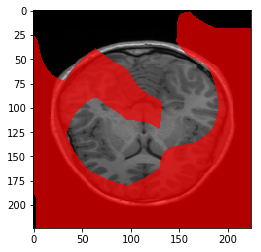

In [15]:
predict_slice = 50

out = model.predict(X_train[predict_slice])
print("Original:", out.shape)
out = out.squeeze()
print("Reshaped:", out.shape)

fig, ax = plt.subplots(1, 1)

img_labels = np.argmax(out, axis=2)

ax.imshow(X_train[predict_slice].squeeze()[:, :, 1].T, cmap='gray')
ax.imshow(np.ma.masked_where(img_labels<.5, img_labels), alpha=.7,
          cmap='autumn', interpolation='none')

In [19]:
model.train_on_batch(X_train, y_train)

ValueError: Error when checking input: expected slice_input to have 4 dimensions, but got array with shape (128, 256, 256)

In [ ]:

weight_decay = 0.

model_vgg16_conv = VGG16(include_top=True, weights='imagenet')
# model_vgg16_conv.trainable = False

input_ = Input(shape=(256, 256, 3), name='slice_input')
output_vgg16_conv = model_vgg16_conv(input_)

x = Flatten(name='flatten')(output_vgg16_conv)
# x = Convolution2D(4096, 7, 7, activation='relu', border_mode='same', name='fc1', W_regularizer=l2(weight_decay))(output_vgg16_conv)
x = Dense(4096, activation='relu', name='fc1')(x)
x = Dense(4096, activation='relu', name='fc2')(x)
# Classifying layer.
x = Convolution2D(2, 1, 1, init='he_normal', activation='linear', border_mode='valid', subsample=(1, 1), W_regularizer=l2(weight_decay))(x)
x = BilinearUpSampling2D(size=(32, 32))(x)
model = Model(input_, x)

In [ ]:
# https://gist.github.com/fchollet/f35fbc80e066a49d65f1688a7e99f069



In [ ]:
model = VGG16(include_top=True, weights='imagenet')
model.trainable = False
print(model.summary())

In [ ]:
inp = Input(shape=(1,224,224))

In [ ]:
x = model(inp)

In [ ]:
out = model.predict(X_train[10])
print(np.argmax(out))

In [ ]:
model.summary()

In [ ]:
# one_slice = Input(shape=(None, 256, 256, 3))
cnn = VGG16(include_top=True, weights='imagenet')
cnn.trainable = False

In [ ]:
x = Dense(128, activation='relu')(cnn)
outputs = Dense(1000)(x)